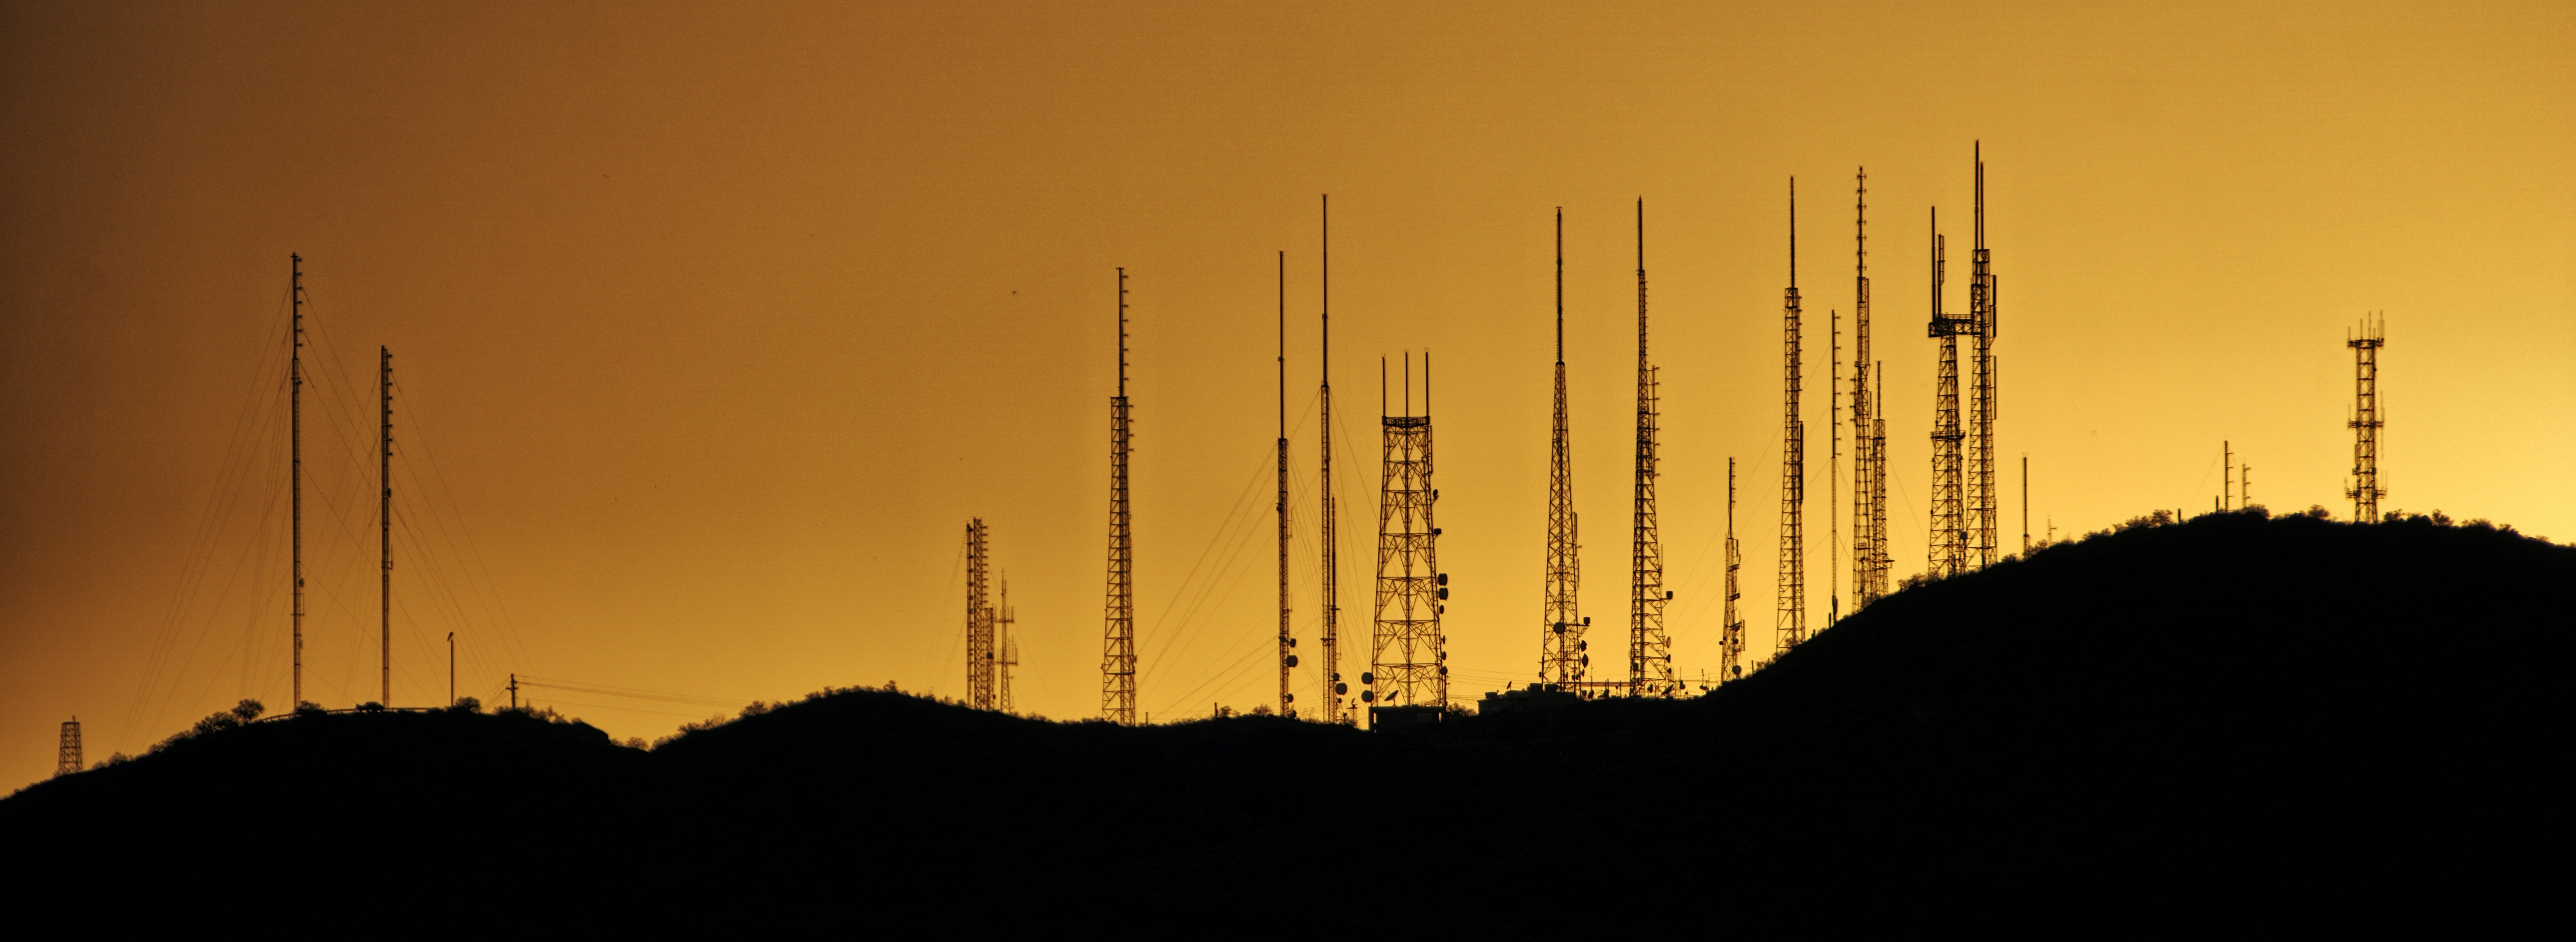
                                                                 photo credit: Troy Squillaci on Pexel

# Churn In Telecom
Elimelech Berlin  
June 2023

## Overview
This report examines data about phone usage to gain understanding of factors that can be used to predict churn, or customers closing acounts or canceling service subscrition, from a telecommunications coompany. This report aims to build a model that can accurately predict which customers will soon abandon a service provider, equiping the business with a key tool in strategizing to retain them/reduce further customer loss. 

## Business Problem
One of the greatest business challenges to providers of telecommunication services is customer churn. Although customers may leave a provider for a number of reasons, identifying which customers will cancel their services will enable the provider to engage in targeted efforts to retain their business.
***

## Data
The dataset used for this project is the [Churn in Telecom's Dataset](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset) available from Kaggle.  
Included in this data is information describing 3k+ US telecom accounts, & records details such as location, plan details, a variety of types of usage minutes and, most importantly, churn status.
***

## Data Preparation 
In this section we prepare the data for modeling. Included in this is loading the data, removing irrelevant information & performing any necesarry transformation of values. 

>As in any such analysis, begin by importing all needed libraries:

In [175]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

Load & examine the data:

In [176]:
# load the data into a datframe
df = pd.read_csv('data/bigml_59c28831336c6604c800002a.csv')

# view a sample of the data
df.head()

state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...  total eve calls  total eve charge  \
0             45.07  ...               99             16.78   
1             27.47  ...              103             16.62   
2             41.38  ...              110             10.30   
3             50.90  ...               88              5.26   
4             28.34  ...              122             12.61   

   total night minutes  total night calls  total night charge  \
0                244.7                 91               11.01   
1                254.4                103               11.45   
2                162.6                104                7.32   
3                196.9                 89                8.86   
4                186.9                121                8.41   

   total intl minutes  total intl calls  total intl charge  \
0                10.0                 3               2.70   
1                13.7                 3               3.70   
2                12.2                 5               3.29   
3                 6.6                 7               1.78   
4                10.1                 3               2.73   

   customer service calls  churn  
0                       1  False  
1                       1  False  
2                       0  False  
3                       2  False  
4                       3  False  

[5 rows x 21 columns]

In [177]:
# view column names to understand context
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

>The column names are all self explanatory. All but the last column, `'churn'`, will be considered predictors for the target value `'churn'`. 
Of the columns present, `'phone number'` & `'area code'` are the only ones which are clearly irrelevant to our investigation; let's proceed by deleting them from the dataset:

In [178]:
# drop the 'phone_number' column from dataset
df.drop(['phone number', 'area code'], axis=1, inplace=True)

Check for missing values:

In [179]:
df.isna().sum()

state                     0
account length            0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

> No missing values to worry about!

To prepare the data for modeling we need to transform any non-numerical data. Columns with binary values can be simply mapped to 0 or 1, non-binary columns must be one-hot-encoded.  
Let's have a look at the datatypes present in the dataframe:

In [180]:
# view dataset datatypes
df.dtypes

state                      object
account length              int64
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

> There are 3 non-numeric type columns. The `'state'` column has more than 2 values & must be one-hot encoded; `'international plan'` & `'voicemail plan'` are binomial & can be transformed to 1 or 0.

Let's convert all three columns with the appropriate methods:

In [181]:
# convert binomial values to numeric datatype: (True, 'yes': 1), (False, 'no': 0)
# loop through columns & convert values if binary
for col in df.columns:
    if len(df[col].unique()) == 2:
        df[col] = df[col].map({True: 1, False: 0, 'yes': 1, 'no': 0})

In [182]:
# one-hot encode'state' column
ohe_df = pd.get_dummies(df)
# preview modified dataframe
ohe_df.head()

account length  international plan  voice mail plan  number vmail messages  \
0             128                   0                1                     25   
1             107                   0                1                     26   
2             137                   0                0                      0   
3              84                   1                0                      0   
4              75                   1                0                      0   

   total day minutes  total day calls  total day charge  total eve minutes  \
0              265.1              110             45.07              197.4   
1              161.6              123             27.47              195.5   
2              243.4              114             41.38              121.2   
3              299.4               71             50.90               61.9   
4              166.7              113             28.34              148.3   

   total eve calls  total eve charge  ...  state_SD  state_TN  state_TX  \
0               99             16.78  ...         0         0         0   
1              103             16.62  ...         0         0         0   
2              110             10.30  ...         0         0         0   
3               88              5.26  ...         0         0         0   
4              122             12.61  ...         0         0         0   

   state_UT  state_VA  state_VT  state_WA  state_WI  state_WV  state_WY  
0         0         0         0         0         0         0         0  
1         0         0         0         0         0         0         0  
2         0         0         0         0         0         0         0  
3         0         0         0         0         0         0         0  
4         0         0         0         0         0         0         0  

[5 rows x 69 columns]

With all of the data accessible numerically, let's check each column's correlation with the target ('churn') to choose which features to include in our modeling:  
* Visualize the correlation each feature with every other feature. 
* Create a short list of the features most correlated with 'churn'. (Along the way, any 2 independent features with high correlation will have one of those features excluded to avoid problems of multicollinearity.)

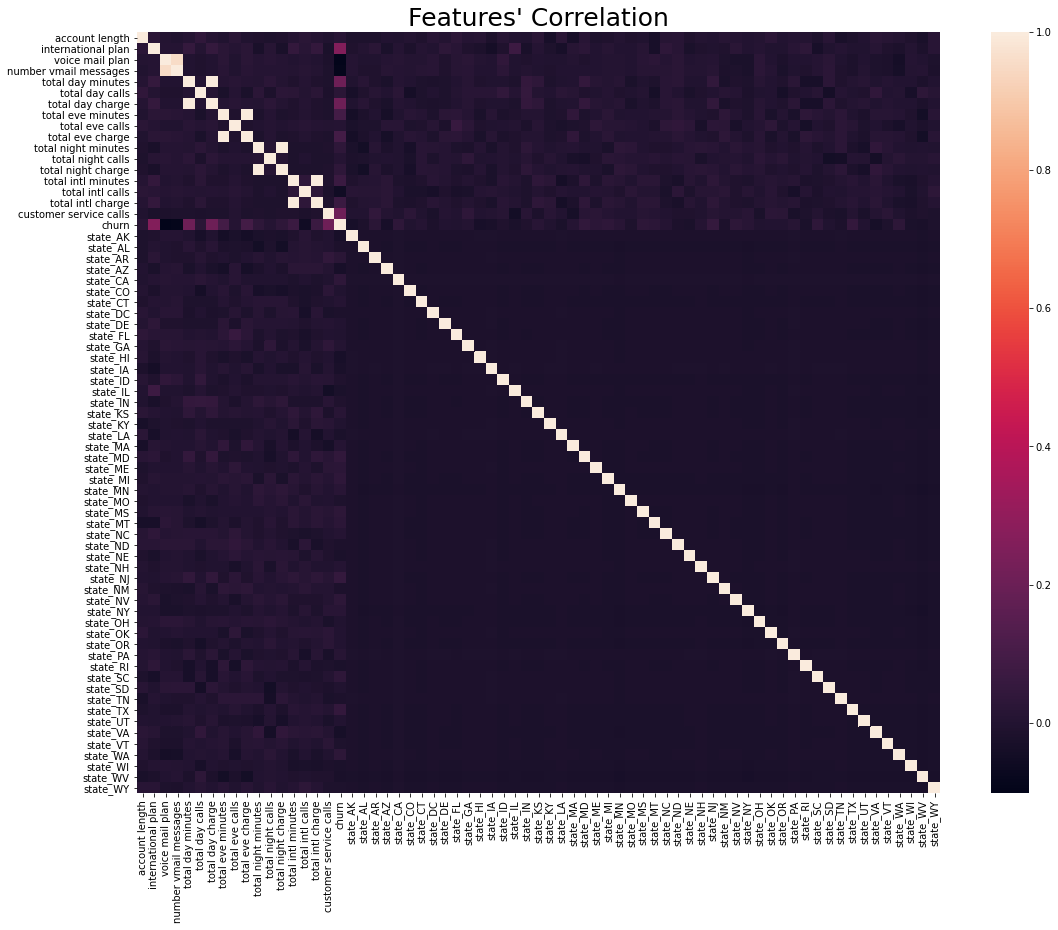

In [183]:
# visualize a heatmap of feature correlation
fig, axes = plt.subplots(figsize=(18, 14))
sns.heatmap(ohe_df.corr())
axes.set_title("Features' Correlation", {'fontsize' : 25});

In [184]:
# create a list of 5 column names most correlated with 'churn' (exclude columns correlated with each other to avoid multicollinearity)
high_corr_lst = df.corr()['churn'].abs().round(3).sort_values()[-8:].drop_duplicates().keys().drop('churn')
# display most highly correlated features & their correlation 
df.corr()['churn'][high_corr_lst]

total eve minutes         0.092796
voice mail plan          -0.102148
total day minutes         0.205151
customer service calls    0.208750
international plan        0.259852
Name: churn, dtype: float64

> Because of high correlation between voicemail plan & number of voicemails, the `'number vmail messages'` feature was removed.  
Based on the above calculations, the following features will be the focus of our modeling:
> * Predictor features:
>  - total eve minutes
>  - voice mail plan (negatively correlated with target)
>  - total day minutes
>  - customer service calls
>  - international plan
> * Target feature:
>  - churn 

Before building any proceeding with actually constructing models to explain the data, the values need to be scaled to avoid issues arising from different ___________ .  
However, to avoid any data leakage at this step, a train-test split should first be done.


In [185]:
# assign X & y variables
X = ohe_df[high_corr_lst]
y = ohe_df[['churn']]
# split data into train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=76)

Now, scale the data:

In [186]:
# scale the data
# instantiate a scaler, fit it to the training data, & transform both subsets of the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [187]:
# view class distribution
y_train.value_counts(normalize=True)

churn
0        0.851463
1        0.148537
dtype: float64

>With such a strong class imbalance, it will be necessary to address it when constructing the models.

> With the data sorted, transformed, divided, scaled & the relevant columns identified, it's now time to proceed with modeling the data.

## Modeling
In this section we begin with a basic logistic regression classifier model & iteratively move towards more complex and precise models.
> When evaluating each models' performance, we need to consider the same metric. What to consider as the most important performance metric, however, is unclear, as it largely depends on unknown information (cost to target specific customers vs. cost of losing customers).  
This report focuses on **f1-score** as we need to balance our need to identify every customer who will leave & target them accordingly, with care to avoid wasting resources on customers who aren't going to leave.  
Throughout this report, positive prediction (1) indicates that a customer will churn, negative (0) indicates failure to churn.

Clarify what true/false negative/positive mean in this project's discussion.

### Logistic Regression Classifier
We begin with a logisitc regression object with default regularization & than contrast that with other models with other regularization levels to see if we can find a model with a better fit.

Build a model with training data & generate predictions for both data subsets:

In [188]:
# instantiate a logistic regression model, fit it to the train data & generate predictions for both data subsets
# set class_weight parameter to balanced to address class imblalance
baseline_log = LogisticRegression(class_weight= 'balanced')
baseline_log.fit(X_train_scaled, y_train)
train_y_hat = baseline_log.predict(X_train_scaled)
test_y_hat = baseline_log.predict(X_test_scaled)

View models' evaluation metrics:

In [189]:
# train data
print('Train Data:\n', pd.DataFrame(classification_report(y_train, train_y_hat, output_dict=True)).transpose())

# test data
print('\nTest Data:\n', pd.DataFrame(classification_report(y_test, test_y_hat, output_dict=True)).transpose())

Train Data:
               precision    recall  f1-score      support
0              0.945346  0.769604  0.848470  2270.000000
1              0.360636  0.744949  0.485997   396.000000
accuracy       0.765941  0.765941  0.765941     0.765941
macro avg      0.652991  0.757277  0.667233  2666.000000
weighted avg   0.858495  0.765941  0.794629  2666.000000

Test Data:
               precision    recall  f1-score     support
0              0.961123  0.767241  0.853308  580.000000
1              0.338235  0.793103  0.474227   87.000000
accuracy       0.770615  0.770615  0.770615    0.770615
macro avg      0.649679  0.780172  0.663767  667.000000
weighted avg   0.879877  0.770615  0.803862  667.000000


>The model better predicts the training data than the testing data.  
The test f1-score of .47 is low and is largely influenced by the low precision (.33) for class 1 (positive churn). This means that although the model can predict nearly 80% of the customers who will churn, it does so at a price of mistakenly identifying churners, nearly two-thirds of the time! (Two-thirds of customers identified as churners, aren't actually churners.) 

Now, let's try models with different levels of regularization to see if we can find a better fit:

In [190]:
# logistic regression with various regularization levels
f1_ls = {}

for see in [2, 20, 200, 2000, 20000]:
    log_reg = LogisticRegression(class_weight='balanced', C = see, random_state=42)
    log_reg.fit(X_train_scaled, y_train)
    test_pred = log_reg.predict(X_test_scaled)
    f1_ls[see] = f1_score(y_test, test_pred)
    
# a dictionary of regularization levels as keys & model f1-scores as values
f1_ls    

{2: 0.4742268041237113,
 20: 0.4742268041237113,
 200: 0.4742268041237113,
 2000: 0.4742268041237113,
 20000: 0.4742268041237113}

> Changing the regularzation levels has very little effect on the model's performance; changing this hyperparameter unnecessarily complicates the model. The original model performs the best.

### Random Forest Classifier
Now, let's see if we can achieve better predictive performance with an ensemble algorithm, a random forest classifier.  
First we will build a vanilla  model with default hyperparameters against which to compare subsequent models.

Build a model with training data & generate predictions for both data subsets:

In [191]:
# instantiate random forest classifier
rfc = RandomForestClassifier(class_weight='balanced', random_state=42)

# fit classifier to training data
rfc.fit(X_train_scaled, y_train)

# generate predictions for train/test data
rfc_train_pred = rfc.predict(X_train_scaled)
rfc_test_pred = rfc.predict(X_test_scaled)

View evaluation metrics for both data subsets:

In [192]:
# train data
print('Train Data:\n', pd.DataFrame(classification_report(y_train, rfc_train_pred, output_dict=True)).transpose())

# test data
print('\nTest Data:\n', pd.DataFrame(classification_report(y_test, rfc_test_pred, output_dict=True)).transpose())

Train Data:
               precision  recall  f1-score  support
0                   1.0     1.0       1.0   2270.0
1                   1.0     1.0       1.0    396.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   2666.0
weighted avg        1.0     1.0       1.0   2666.0

Test Data:
               precision    recall  f1-score     support
0              0.941077  0.963793  0.952300  580.000000
1              0.712329  0.597701  0.650000   87.000000
accuracy       0.916042  0.916042  0.916042    0.916042
macro avg      0.826703  0.780747  0.801150  667.000000
weighted avg   0.911241  0.916042  0.912869  667.000000


> The training model with default parameters performs perfectly.
The model didn't work as well on the testing data, a sign of overfitting.  
Although over 70% of customers identified as churners are actually churners, the model failed to identify nearly 40% of those who churned. Based on the f1-score of .65, this model is the best classifier thus far.

Now, let's see if we can indentify a model that better predicts our target. To do so we implement GridSearchCv which combines an exhaustive search technique with cross validation to find the best hyperparameters for our model.  
The following procedure will be followed:
* Define a grid of several parameters with a list of values for each parameter
* Instantiate Grid Search object using the RFC classifier created earlier & parameter grid
* Fit GS object to training data
* Identify best parameters found through Grid Search
* Evaluate model performance on training & testing data

In [193]:
# define search grid
rfc_grid = {'criterion': ['gini', 'entropy'],
            'max_depth': [5, 10, 15, 20, 25],
            'min_samples_leaf': [2, 6, 10, 14, 18, 22],
            'min_samples_split': [2, 5, 10]}

# instantiate grid search object
grid_search_rfc = GridSearchCV(rfc, rfc_grid, scoring='f1', return_train_score=True)

In [194]:
%%time
# fit grid search object to training data
# this cell will run a total of 900 random forest classifiers
grid_search_rfc.fit(X_train_scaled, y_train)

Wall time: 3min 59s


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, 25],
                         'min_samples_leaf': [2, 6, 10, 14, 18, 22],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='f1')

In [195]:
# view model's best hyperparameters
grid_search_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

Let's have a look at the classification report for the predictions on the data subsets:

In [196]:
# generate train predictions
rfc_gs_train_pred = grid_search_rfc.predict(X_train_scaled)

# generate test predictions
rfc_gs_test_pred = grid_search_rfc.predict(X_test_scaled)

# view a dataframe of the evaluation metrics
# train data
print('Train Data:\n', pd.DataFrame(classification_report(y_train, rfc_gs_train_pred, output_dict=True)).transpose())

# test data
print('\nTest Data:\n', pd.DataFrame(classification_report(y_test, rfc_gs_test_pred, output_dict=True)).transpose())

Train Data:
               precision    recall  f1-score      support
0              0.987273  0.956828  0.971812  2270.000000
1              0.789700  0.929293  0.853828   396.000000
accuracy       0.952738  0.952738  0.952738     0.952738
macro avg      0.888486  0.943061  0.912820  2666.000000
weighted avg   0.957926  0.952738  0.954287  2666.000000

Test Data:
               precision    recall  f1-score     support
0              0.971223  0.931034  0.950704  580.000000
1              0.639640  0.816092  0.717172   87.000000
accuracy       0.916042  0.916042  0.916042    0.916042
macro avg      0.805431  0.873563  0.833938  667.000000
weighted avg   0.927973  0.916042  0.920243  667.000000


> The training model scored higher than the testing model; a sign of overfitting. 
The f1-score (.71) of this model on the testing data is better than the previous model. It results from a mediocre precision score of .63 (3 out of 5 customers identified as churners are truly churners) & a recall score of .81 (4 out of 5 of churners are 'caught'). 

### XGBoost
Finally, let's unleash the power of one of the most advanced gradiant boosting classifiers, XGBoost.
Similar to the pattern established above, we begin with a classifier set to default hyperparameters & than attempt to improve on it.

In [197]:
# instantiate classifier
ex_gb = XGBClassifier(random_state=42)

# fit to training data
ex_gb.fit(X_train_scaled, y_train)

# generate predictions for both subsets of data
xg_train_pred = ex_gb.predict(X_train_scaled)
xg_test_pred = ex_gb.predict(X_test_scaled)

View model evaluation metrics:

In [198]:
# train data
print('Train Data:\n', pd.DataFrame(classification_report(y_train, xg_train_pred, output_dict=True)).transpose())

# test data
print('\nTest Data:\n', pd.DataFrame(classification_report(y_test, xg_test_pred, output_dict=True)).transpose())

Train Data:
               precision    recall  f1-score      support
0              0.985243  1.000000  0.992567  2270.000000
1              1.000000  0.914141  0.955145   396.000000
accuracy       0.987247  0.987247  0.987247     0.987247
macro avg      0.992622  0.957071  0.973856  2666.000000
weighted avg   0.987435  0.987247  0.987008  2666.000000

Test Data:
               precision    recall  f1-score    support
0              0.942857  0.967241  0.954894  580.00000
1              0.736111  0.609195  0.666667   87.00000
accuracy       0.920540  0.920540  0.920540    0.92054
macro avg      0.839484  0.788218  0.810780  667.00000
weighted avg   0.915890  0.920540  0.917299  667.00000


> The training data does very well at predicting churn with a f1-score of .95, the testing data doesn't perform nearly as well; a sign of overfitting.  
The test f1-score of .66 results from precision score of .73 & recall of only .60.  
This model isn't as good as the best random forest classifier (f1-score of .71) found in the previous subsection of this report.

Now, let's see if we can build a better model using GridSearchCv, as done with the random forest classifier. As earlier, the following procedure will be followed:
* Define a grid of several parameters with a list of values for each parameter
* Instantiate Grid Search object using the XGBoost classifier created earlier & parameter grid
* Fit GS object to training data
* Identify best parameters found through Grid Search
* Evaluate model performance on training & testing data

Define parameter grid:

In [199]:
# define a grid of hyperparameters
xgb_grid = {'learning_rate': [0.1, 0.2],
            'max_depth': [6],
            'min_child_weight': [1, 2],
            'subsample': [0.5, 0.7],
            'n_estimators': [100]}

Instantiate GridSearchCv object & fit it to training data:

In [200]:
# instantiate grid search object
xgb_gs = GridSearchCV(ex_gb, xgb_grid, scoring='f1',cv=5)

# fit gs object to training data
xgb_gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                   

In [201]:
# diplay parameters of best model
xgb_gs.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 100,
 'subsample': 0.7}

Generate predictions for both data subsets & display their evaluation metrics:

In [202]:
# generate predictions for both sets of data

# train predictions
xgbgs_train_pred = xgb_gs.predict(X_train_scaled)

# test predictions
xgbgs_test_pred = xgb_gs.predict(X_test_scaled)

# show evaluation metrics for both sets of data
# train data
print('Train Data:\n', pd.DataFrame(classification_report(y_train, xgbgs_train_pred, output_dict=True)).transpose())

# test data
print('\nTest Data:\n', pd.DataFrame(classification_report(y_test, xgbgs_test_pred, output_dict=True)).transpose())

Train Data:
               precision    recall  f1-score      support
0              0.964957  0.994714  0.979610  2270.000000
1              0.963190  0.792929  0.869806   396.000000
accuracy       0.964741  0.964741  0.964741     0.964741
macro avg      0.964074  0.893821  0.924708  2666.000000
weighted avg   0.964695  0.964741  0.963300  2666.000000

Test Data:
               precision    recall  f1-score     support
0              0.940199  0.975862  0.957699  580.000000
1              0.784615  0.586207  0.671053   87.000000
accuracy       0.925037  0.925037  0.925037    0.925037
macro avg      0.862407  0.781034  0.814376  667.000000
weighted avg   0.919906  0.925037  0.920310  667.000000


identify best model, view feature importance & base recommendations on them. also make visualizations to meet project requirment

#### Features

Of all of the models utilized, GridSearchCv identified the best one, an XGBoost classifier with an f1-score of _.  
As we work towards tangible solutions to our business problem, we follow the following steps:
* fit a new XGBoost classifier with best parameters, to the training data
* get features' importance of the model
* create a dictionary of features as keys & importance as values; cast to a dataframe
* view bar plot of features & their importance

Create a new model & fit it to the training data:

In [205]:
# instantiate new XGBoost classifier using the best hyperparameters
best_xgb = XGBClassifier(**xgb_gs.best_params_)

# fit it to training data
best_xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Create a dictionary of features' importance, cast it to a dataframe & view plot:

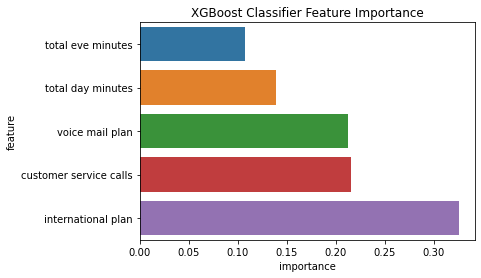

In [289]:
# instantiate empty dictionary
xgb_features_dict = {}

# iterate over features & add them as keys, with their importance as values to the dictionary
for f, i in enumerate(best_xgb.feature_importances_):
    xgb_features_dict[best_xgb.feature_names_in_[f]] = i

# create a dataframe of feature importance    
xgb_feat = pd.DataFrame([features_dict]).transpose().rename_axis(['feature']).rename(columns={0: 'importance'}).sort_values(by='importance').reset_index()

# view a plot of features' importance
sns.barplot(xgb_feat['importance'], xgb_feat['feature'], orient='h')
plt.title('XGBoost Classifier Feature Importance');

of the above models, grid_search_rfc.best_params_ is the model with the best f1-score.so let's get features importance to understand what type type of business aadvice we can glean

In [240]:
best_rfc = RandomForestClassifier(**grid_search_rfc.best_params_)

In [242]:
best_rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10)

In [247]:
best_rfc.

array([0.22913524, 0.0521591 , 0.44968152, 0.17498436, 0.09403977])

In [254]:
rfc_features_dict = {}

for f, i in enumerate(best_rfc.feature_importances_):
    rfc_features_dict[best_rfc.feature_importances_[f]] = i

# view a dataframe of features & their importance in ascending order of importance     
pd.DataFrame([rfc_features_dict]).transpose().rename_axis(['feature']).rename(columns={0: 'importance'}).sort_values(by='importance')

# plt.bar(xgb_feat['feature'], xgb_feat['importance'])

importance
feature             
0.229135    0.229135
0.052159    0.052159
0.449682    0.449682
0.174984    0.174984
0.094040    0.094040

In [259]:
features_dict

{'total eve minutes': 0.10750228,
 'voice mail plan': 0.21239,
 'total day minutes': 0.13873143,
 'customer service calls': 0.21589787,
 'international plan': 0.32547843}